# LSTM과 GRU 셀

In [1]:
from keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input,train_target),(test_input,test_target)=imdb.load_data(num_words=500)
train_input,val_input,train_target,val_target=train_test_split(train_input,train_target,test_size=0.2,random_state=42)

from keras.preprocessing.sequence import pad_sequences

train_seq=pad_sequences(train_input,maxlen=100)
val_seq=pad_sequences(val_input,maxlen=100)

import torch

train_seq=torch.tensor(train_seq)
val_seq=torch.tensor(val_seq)
train_target=torch.tensor(train_target,dtype=torch.float32)
val_target=torch.tensor(val_target,dtype=torch.float32)

from torch.utils.data import TensorDataset,DataLoader

train_dataset=TensorDataset(train_seq,train_target)
val_dataset=TensorDataset(val_seq,val_target)

train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False)

In [5]:
import torch.nn as nn

class IMDBLstm(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding=nn.Embedding(500,16)
        self.lstm=nn.LSTM(16,8,batch_first=True,num_layers=2,dropout=0.2)
        self.dense=nn.Linear(8,1)
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.embedding(x)
        _,(hidden,_)=self.lstm(x)
        outputs=self.dense(hidden[-1])
        return self.sigmoid(outputs)

In [6]:
model=IMDBLstm()

import torch

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

import torch.optim as optim

criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters())

train_hist=[]
val_hist=[]
patience=2
best_loss=-1
early_stopping_counter=0

epochs=100
for epoch in range(epochs):
    model.train()
    train_loss=0
    for inputs,targets in train_loader:
        inputs,targets=inputs.to(device),targets.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs.squeeze(),targets)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    model.eval()
    val_loss=0
    with torch.no_grad():
        for inputs,targets in val_loader:
            inputs,targets=inputs.to(device),targets.to(device)
            outputs=model(inputs)
            loss=criterion(outputs.squeeze(),targets)
            val_loss+=loss.item()

    train_loss=train_loss/len(train_loader)
    val_loss=val_loss/len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f'에포크:{epoch+1},',
          f'훈련 손실:{train_loss:.4f}, 검증 손실:{val_loss:.4f}')
    
    if best_loss==-1 or val_loss<best_loss:
        best_loss=val_loss
        early_stopping_counter=0
        torch.save(model.state_dict(),'best_2lstm_model.pt')
    else:
        early_stopping_counter+=1
        if early_stopping_counter>=patience:
            print(f'{epoch+1}번째 에포크에서 조기 종료되었습니다.')
            break

에포크:1, 훈련 손실:0.6890, 검증 손실:0.6655
에포크:2, 훈련 손실:0.6284, 검증 손실:0.5965
에포크:3, 훈련 손실:0.5719, 검증 손실:0.5522
에포크:4, 훈련 손실:0.5302, 검증 손실:0.5156
에포크:5, 훈련 손실:0.4947, 검증 손실:0.4936
에포크:6, 훈련 손실:0.4736, 검증 손실:0.4759
에포크:7, 훈련 손실:0.4557, 검증 손실:0.4882
에포크:8, 훈련 손실:0.4484, 검증 손실:0.4625
에포크:9, 훈련 손실:0.4344, 검증 손실:0.4601
에포크:10, 훈련 손실:0.4261, 검증 손실:0.4548
에포크:11, 훈련 손실:0.4209, 검증 손실:0.4431
에포크:12, 훈련 손실:0.4169, 검증 손실:0.4458
에포크:13, 훈련 손실:0.4129, 검증 손실:0.4353
에포크:14, 훈련 손실:0.4088, 검증 손실:0.4341
에포크:15, 훈련 손실:0.4011, 검증 손실:0.4320
에포크:16, 훈련 손실:0.3947, 검증 손실:0.4365
에포크:17, 훈련 손실:0.3957, 검증 손실:0.4339
17번째 에포크에서 조기 종료되었습니다.


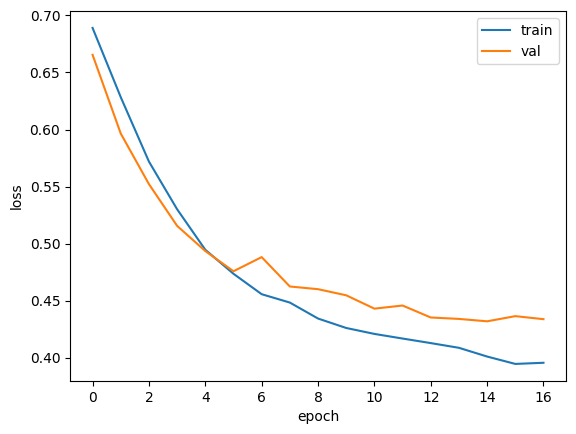

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_hist,label='train')
plt.plot(val_hist,label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [8]:
model.load_state_dict(torch.load('best_2lstm_model.pt',weights_only=True))

model.eval()
corrects=0
with torch.no_grad():
    for inputs,targets in val_loader:
        inputs,targets=inputs.to(device),targets.to(device)
        outputs=model(inputs)
        predicts=outputs>0.5
        corrects+=(predicts.squeeze()==targets).sum().item()

accuracy=corrects/len(val_dataset)
print(f'검증정확도: {accuracy:.4f}')

검증정확도: 0.7972


In [9]:
test_seq=pad_sequences(test_input,maxlen=100)
test_seq=torch.tensor(test_seq)
test_target=torch.tensor(test_target,dtype=torch.float32)

test_dataset=TensorDataset(test_seq,test_target)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

model.eval()
corrects=0
with torch.no_grad():
    for inputs,targets in test_loader:
        inputs,targets=inputs.to(device),targets.to(device)
        outputs=model(inputs)
        predicts=outputs>0.5
        corrects+=(predicts.squeeze()==targets).sum().item()

accuracy=corrects/len(test_dataset)
print(f'테스트 정확도: {accuracy:.4f}')

테스트 정확도: 0.8038
